In [ ]:
cd ..

In [ ]:
import tensorflow as tf
import numpy as np
from src.operators.measurement import NUFFT_op, NUFFT_op_TF

# from tensorflow.python.framework.ops import disable_eager_execution
# disable_eager_execution()

In [ ]:
class TF_nufft(NUFFT_op):
    """ Tensorfow adaptation of the nufft operator""" 
    def forward(self, x):
        return tf.numpy_function(self.dir_op, [x], tf.complex64)

    def adjoint(self, x):
        return tf.numpy_function(self.adj_op, [x], tf.complex64)

In [ ]:
class Gradient(tf.keras.layers.Layer):
    def __init__(self, m_op, shape_x, shape_y, depth):
        self.m_op = m_op
        self.input_spec = [
            tf.keras.layers.InputSpec(
                dtype=tf.float32,
                shape=shape_x
            ),
            tf.keras.layers.InputSpec(
                dtype=tf.complex64,
                shape=shape_y
            )
        ]
        self.depth = depth +1
        self.trainable=False
    

    def __call__(self, x, y):
        x = tf.cast(x, tf.complex64)
        m = self.m_op.forward(x) 
        size = y.shape[1]
        res = m -  y
        grad = self.m_op.adjoint( res )
        return tf.cast(grad, tf.float32)

In [5]:
x_tf = tf.convert_to_tensor(np.ones((1,256,256,1)))
y_tf = tf.cast(tf.convert_to_tensor(np.ones((1,4440,1)) +0j), tf.complex64)

In [ ]:
g = Gradient(op, [None, 256,256], [None, 4440], 0)

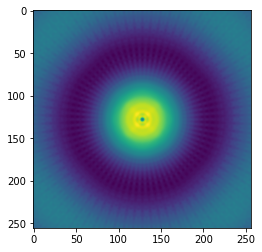

In [29]:
plt.imshow(g(x_tf[None, :,:], y_tf[None, :]).numpy().real)

In [30]:
gradient_layers = []
depth = 4
for i in range(depth):
    m_op = TF_nufft()
    nd, kd = (Nd[0]//2**i, Nd[1]//2**i), (Kd[0]//2**i, Kd[1]//2**i)
    print(nd, kd)
    sel = np.linalg.norm(uv, axis=1) < np.pi / 2**i
    m_op.plan(uv[sel], nd, kd, Jd)
    gradient_layers.append( Gradient(m_op, [None, nd[0], nd[1]], [None, np.sum(sel)], i) )

 12%|█▏        | 533/4440 [00:00<00:00, 5328.71it/s]

(256, 256) (512, 512)


 12%|█▏        | 534/4414 [00:00<00:00, 5330.41it/s]

(128, 128) (256, 256)


 18%|█▊        | 535/2960 [00:00<00:00, 5347.71it/s]

(64, 64) (128, 128)


 35%|███▌      | 522/1480 [00:00<00:00, 5216.60it/s]

(32, 32) (64, 64)


100%|██████████| 1480/1480 [00:00<00:00, 5204.31it/s]


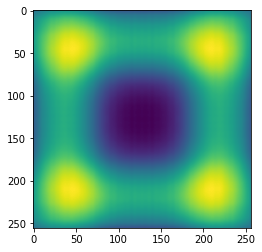

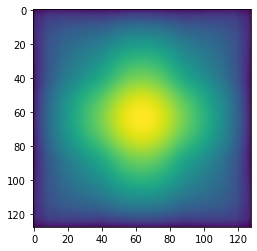

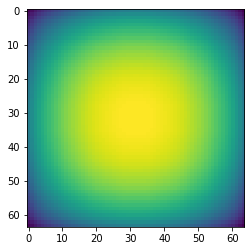

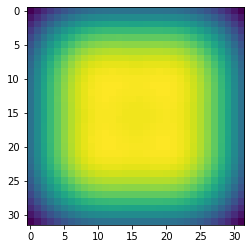

In [31]:
for i in range(depth):
    x_tf = tf.convert_to_tensor(np.ones((1, Nd[0]//2**i, Nd[1]//2**i)))
    y_tf = tf.convert_to_tensor(0j + np.ones((1,np.sum(np.linalg.norm(uv, axis=1) < np.pi / 2**i))))

    plt.imshow(gradient_layers[i](x_tf, y_tf).numpy().real)
    plt.show()

In [32]:
x_tf

<tf.Tensor: shape=(1, 32, 32), dtype=float64, numpy=
array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]])>

In [33]:
# from src.network import medium_unet, small_unet

In [34]:
from src.sampling.uv_sampling import spider_sampling
uv = spider_sampling()

In [35]:
model = medium_unet(uv=uv, grad=True)

 11%|█         | 484/4440 [00:00<00:00, 4835.77it/s]

(256, 256) (512, 512)


 12%|█▏        | 533/4414 [00:00<00:00, 5328.10it/s]

(128, 128) (256, 256)


 18%|█▊        | 526/2960 [00:00<00:00, 5259.11it/s]

(64, 64) (128, 128)


 36%|███▌      | 536/1480 [00:00<00:00, 5359.69it/s]

(32, 32) (64, 64)


100%|██████████| 1480/1480 [00:00<00:00, 5316.11it/s]


In [36]:
model.summary()

Model: "unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 4440, 1)]    0                                            
__________________________________________________________________________________________________
tf_op_layer_boolean_mask/Shape  [(3,)]               0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_boolean_mask/stride [(1,)]               0           tf_op_layer_boolean_mask/Shape[0]
__________________________________________________________________________________________________
tf_op_layer_boolean_mask/Shape_ [(3,)]               0           input_2[0][0]                    
_______________________________________________________________________________________________

In [37]:
import tensorflow as tf
import numpy as np

In [38]:
i=1
sel = np.linalg.norm(uv, axis=1) < np.pi / 2**i


In [39]:
y = tf.convert_to_tensor(np.ones((10, 4440,1)))

In [40]:
tf.boolean_mask(y, sel, axis=1)

<tf.Tensor 'boolean_mask_4/GatherV2:0' shape=(10, None, 1) dtype=float64>